<a href="https://colab.research.google.com/github/SoulMUSZE/Machine-Learning-with-Python/blob/master/Inflow_hts_fbprophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [4]:
!ls "/content/drive/MyDrive/Colab Notebooks/data"

ctt_created.csv  inflow.csv  inflow.gsheet  zone.csv  zone_product.csv


In [6]:
!pip install scikit-hts

     |████████████████████████████████| 9.8 MB 11.8 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [7]:
import pandas as pd
import hts
from fbprophet import Prophet 
from sklearn.metrics import mean_squared_error
import math
import matplotlib.pyplot as plt
from os.path import exists as file_exists
import os
import collections
import datetime

import seaborn as sns
sns.set_style('darkgrid', {'axes.facecolor': '.9'})
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')
%matplotlib inline

In [8]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/inflow.csv")
#data link -> https://drive.google.com/file/d/1i6Q8kSHCwDlIyIOTb6q5U4bMG7ZNriUc/view?usp=sharing
dir = "/content/drive/MyDrive/Colab Notebooks/data/"
df["zone"] = df["zone"].str.lower().replace(' ', '_', regex=True) 
df['created_date'] = pd.to_datetime(df['created_date'], format="%d/%m/%Y")
df['zone_product'] = df[['zone', 'product_tagging']].agg('_'.join, axis=1)
df = df.rename(columns={'created_date': 'ds', 'count(distinct order_number)': 'count'})


In [9]:
data_startdate = df['ds'].min()
data_enddate = df['ds'].max()
forecast_startdate = data_enddate + datetime.timedelta(days=1)
forecast_enddate = pd.to_datetime('2022-03-31')
forecast_period = (forecast_enddate - data_enddate).days

In [10]:
df.head()

,ds,order_type,product,region,zone,dp_type,dp_tagging,day_tagging,count,product_tagging,zone_product
0,2020-08-24,Relocate,UniFi,Central 2,zone_tdi,VDSL,OH,weekday,4,modify_vdsl_oh,zone_tdi_modify_vdsl_oh
1,2021-04-17,Modify,HSBA,Central 2,zone_subang_jaya,BAU,OH,weekend,26,modify_bau,zone_subang_jaya_modify_bau
2,2021-09-23,Relocate,UniFi,Northern,zone_alor_setar,FTTH,OH,weekday,1,modify_ftth_oh,zone_alor_setar_modify_ftth_oh
3,2020-08-17,New Install,Streamyx,Southern,zone_pandan,BAU,OH,weekday,5,ni_bau,zone_pandan_ni_bau
4,2021-07-29,Relocate,UniFi,Sarawak,zone_kuching,FTTH,OH,weekday,3,modify_ftth_oh,zone_kuching_modify_ftth_oh


In [108]:
nationwide_group = df.groupby(["ds"])['count'].sum().reset_index().rename(columns={'count': 'nationwide'})

In [109]:
zone_group = df.groupby(["zone","ds"])['count'].sum().unstack(level=0, fill_value=0).reset_index()

In [110]:
zone_product_group = df.groupby(["zone_product","ds"])['count'].sum().unstack(level=0, fill_value=0).reset_index()

In [14]:
zone_product_df_list = list(df.zone_product.unique())

In [15]:
import itertools
zones = df.zone.unique()
product_tags = df.product_tagging.unique()

zone_product_df = pd.DataFrame(list(itertools.product(zones,product_tags)),columns=['zone','product_tagging'])
zone_product_df['zone_product_tagging'] = zone_product_df[['zone', 'product_tagging']].agg('_'.join, axis=1)
zone_product_full_list = list(zone_product_df['zone_product_tagging'])

In [16]:
 zone_product_missing_list = list(set(zone_product_full_list).difference(zone_product_df_list))

In [17]:
zone_product_group[zone_product_missing_list] = 0

In [19]:
hts_group = nationwide_group.merge(zone_group,on='ds',how='left').merge(zone_product_group,on='ds',how='left')
hts_group

,ds,nationwide,zone_air_itam,zone_alor_setar,zone_bangi,zone_bangsar,zone_batu_gajah,zone_batu_pahat,zone_bayan_baru,zone_bintulu,zone_bukit_anggerik,zone_bukit_mertajam,zone_bukit_raja_&_k._selangor,zone_butterworth,zone_cyberjaya,zone_dungun_&_chukai,zone_gombak,zone_ipoh,zone_jertih,zone_jitra,zone_kepong_&_batu,zone_keramat,zone_klang,zone_kluang_&_mersing,zone_kota_bahru,zone_kota_kinabalu,zone_kota_tinggi,zone_kuala_kangsar,zone_kuala_terengganu,zone_kuching,zone_kulim,zone_labuan,zone_lahad_datu,zone_langkawi,zone_machang_&_gua_musang,zone_maluri,zone_maran_&_temerloh,zone_melaka_selatan,zone_melaka_utara,zone_miri,...,zone_maran_&_temerloh_ni_vdsl_oh,zone_ns_timur_modify_ftth_ug,zone_ns_timur_ni_vdsl_oh,zone_maran_&_temerloh_modify_vdsl_oh,zone_penang_central_modify_ftth_ug,zone_sibu_modify_vdsl_oh,zone_sibu_modify_ftth_ug,zone_bukit_anggerik_modify_ftth_ug,zone_kuching_modify_ftth_ug,zone_kuala_terengganu_modify_ftth_ug,zone_pbp_utara_ni_vdsl_oh,zone_teluk_intan_modify_ftth_ug,zone_stampin_modify_ftth_ug,zone_kota_bahru_modify_ftth_ug,zone_machang_&_gua_musang_modify_vdsl_oh,zone_setiawan_modify_vdsl_oh,zone_parit_buntar_modify_ftth_ug,zone_kota_tinggi_modify_vdsl_oh,zone_kuala_terengganu_ni_vdsl_oh,zone_sibu_ni_vdsl_oh,zone_segamat_ni_ftth_ug,zone_pekan_ni_vdsl_oh,zone_tasek_modify_vdsl_oh,zone_labuan_modify_ftth_ug,zone_langkawi_modify_ftth_ug,zone_jitra_modify_vdsl_oh,zone_sri_aman_ni_vdsl_oh,zone_parit_buntar_ni_ftth_ug,zone_miri_ni_vdsl_oh,zone_jertih_modify_vdsl_oh,zone_jertih_ni_ftth_ug,zone_segamat_modify_ftth_ug,zone_kuala_kangsar_ni_ftth_ug,zone_sri_aman_ni_ftth_ug,zone_parit_buntar_ni_vdsl_oh,zone_miri_modify_vdsl_oh,zone_kuala_terengganu_ni_ftth_ug,zone_melaka_selatan_ni_ftth_ug,zone_batu_gajah_ni_vdsl_oh,zone_sandakan_modify_vdsl_oh
0,2020-01-01,2047,5,51,90,16,5,53,24,5,28,14,31,16,99,28,79,21,6,43,84,50,45,17,35,22,12,1,42,11,17,1,0,11,12,31,2,12,15,15,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2020-01-02,4091,20,42,166,32,24,66,51,26,79,28,79,36,144,35,141,63,10,26,173,143,83,31,61,129,19,13,46,27,24,8,12,20,15,71,26,70,54,39,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2020-01-03,4195,22,29,186,39,23,19,69,65,91,106,152,42,147,15,179,76,1,13,200,181,108,9,10,160,7,24,13,41,16,6,4,3,1,94,25,95,43,134,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2020-01-04,1519,14,10,60,22,5,16,35,13,37,13,46,14,61,1,72,29,1,22,82,67,42,14,13,42,2,9,4,12,9,2,1,2,0,42,1,47,14,22,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2020-01-05,1832,2,53,70,13,2,43,21,24,29,18,41,23,67,31,83,17,20,24,64,60,48,28,47,27,13,2,37,8,15,1,1,5,10,22,3,19,13,11,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
637,2021-10-01,6824,52,71,323,44,97,48,234,60,85,110,169,99,188,26,180,223,5,25,252,237,121,40,19,140,9,23,50,77,33,12,10,17,33,110,50,135,103,151,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
638,2021-10-02,3229,21,36,162,17,35,42,65,25,43,65,146,42,90,10,90,50,1,9,159,100,69,28,14,66,6,20,19,39,23,0,4,0,12,40,26,109,55,23,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
639,2021-10-03,3223,16,75,118,21,50,103,47,21,46,50,72,37,78,39,70,34,8,21,112,72,75,36,35,54,13,15,76,47,36,4,2,17,50,29,16,132,38,44,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
640,2021-10-04,6631,59,116,196,50,84,127,60,40,103,94,365,76,170,67,213,85,18,58,246,215,125,170,50,105,21,26,76,78,54,16,10,20,71,99,63,139,116,111,...,0,0,0,0

In [20]:
hierarchy = {}
hierarchy['nationwide'] = list(df.zone.unique())
for zone in list(df.zone.unique()):
  hierarchy[zone] = [zone+'_ni_bau',zone+'_ni_ftth_oh',zone+'_ni_ftth_ug',zone+'_ni_vdsl_oh',zone+'_modify_bau',zone+'_modify_ftth_oh',zone+'_modify_ftth_ug',zone+'_modify_vdsl_oh' ]

In [21]:
tree = hts.hierarchy.HierarchyTree.from_nodes(hierarchy, hts_group, root='nationwide')
sum_mat, sum_mat_labels = hts.functions.to_sum_mat(tree)
#replace default label 'total' with custom label 'nationwide'
sum_mat_labels[0] = 'nationwide' 

cols = ['ds'] + sum_mat_labels
forecasts = pd.DataFrame(columns=cols, index=list(range(0,forecast_period)))
forecasts['ds'] = pd.date_range(forecast_startdate, periods=forecast_period, freq='D')

In [23]:
# dictionary to store each fbprophet forecast components
fbprophet_forecasts = {}

In [ ]:
s = 1
# for col in ['nationwide']:
for col in sum_mat_labels:
  e = len(sum_mat_labels)
  print("Column:", col, s, e)
  model = Prophet(growth="linear", daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True,seasonality_mode='multiplicative', interval_width=0.95)
  model.fit(hts_group[['ds', col]].rename(columns={col: 'y'}))
  future = model.make_future_dataframe(periods=forecast_period)
  forecast = model.predict(future)
  # forecasts[col] = list(forecast['yhat'])
  forecasts[col] = list(forecast[forecast['ds']>data_enddate]['yhat'])
  fbprophet_forecasts[col] = forecast
  s += 1

In [25]:
forecasts

,ds,nationwide,zone_pbp_utara,zone_ns_timur,zone_raub,zone_pasir_mas,zone_sri_aman,zone_seberang_jaya,zone_batu_gajah,zone_tar,zone_setiawan,zone_langkawi,zone_sg_petani,zone_pekan,zone_miri,zone_batu_pahat,zone_kluang_&_mersing,zone_jertih,zone_bangsar,zone_tapah,zone_kota_bahru,zone_pbp_selatan,zone_rawang,zone_perlis,zone_taiping,zone_kepong_&_batu,zone_muar,zone_bangi,zone_pelangi,zone_penang_central,zone_butterworth,zone_kulim,zone_jitra,zone_lahad_datu,zone_puchong,zone_gombak,zone_klang,zone_bukit_anggerik,zone_maluri,zone_tawau,...,zone_sri_aman_ni_bau,zone_sri_aman_ni_ftth_oh,zone_sri_aman_ni_ftth_ug,zone_sri_aman_ni_vdsl_oh,zone_sri_aman_modify_bau,zone_sri_aman_modify_ftth_oh,zone_sri_aman_modify_ftth_ug,zone_sri_aman_modify_vdsl_oh,zone_pasir_mas_ni_bau,zone_pasir_mas_ni_ftth_oh,zone_pasir_mas_ni_ftth_ug,zone_pasir_mas_ni_vdsl_oh,zone_pasir_mas_modify_bau,zone_pasir_mas_modify_ftth_oh,zone_pasir_mas_modify_ftth_ug,zone_pasir_mas_modify_vdsl_oh,zone_raub_ni_bau,zone_raub_ni_ftth_oh,zone_raub_ni_ftth_ug,zone_raub_ni_vdsl_oh,zone_raub_modify_bau,zone_raub_modify_ftth_oh,zone_raub_modify_ftth_ug,zone_raub_modify_vdsl_oh,zone_ns_timur_ni_bau,zone_ns_timur_ni_ftth_oh,zone_ns_timur_ni_ftth_ug,zone_ns_timur_ni_vdsl_oh,zone_ns_timur_modify_bau,zone_ns_timur_modify_ftth_oh,zone_ns_timur_modify_ftth_ug,zone_ns_timur_modify_vdsl_oh,zone_pbp_utara_ni_bau,zone_pbp_utara_ni_ftth_oh,zone_pbp_utara_ni_ftth_ug,zone_pbp_utara_ni_vdsl_oh,zone_pbp_utara_modify_bau,zone_pbp_utara_modify_ftth_oh,zone_pbp_utara_modify_ftth_ug,zone_pbp_utara_modify_vdsl_oh
0,2021-10-06,7268.296097,35.008869,27.212589,33.470131,102.758867,17.610286,96.598467,56.180536,62.125687,54.168910,22.602234,114.474247,47.527661,97.286767,110.590067,93.845008,23.734048,57.332089,44.631172,61.212946,39.991689,154.602887,46.389034,63.784883,282.994555,103.983451,286.672781,101.863782,35.712875,91.878636,69.559702,49.918862,5.763140,187.072629,201.841382,169.974874,105.108917,94.243637,29.861292,...,0.038554,13.519376,0.0,0.0,2.866513,0.545857,0.0,0.0,2.786385,92.869602,0.0,0.0,8.410918,1.905639,0.0,0.0,1.883737,22.756159,-0.010833,0.0,8.144160,0.663765,0.000006,0.0,8.991435,15.635413,0.0,0.0,4.469137,0.181591,0.0,0.0,0.229469,34.492688,0.0,0.0,2.900977,0.293455,0.0,0.0
1,2021-10-07,7207.333587,34.963182,27.792577,36.526637,97.846320,15.837999,96.415291,57.975320,62.723807,51.992732,24.218363,110.007111,49.812377,90.298432,104.877883,89.242433,22.653029,58.316016,43.432350,61.431668,36.890099,155.505416,46.451994,63.338392,296.389187,106.486453,286.094723,98.158841,34.925612,91.805947,70.391199,47.032273,4.674104,203.234854,210.686847,171.691545,105.657508,96.788680,30.644429,...,0.044080,11.797971,0.0,0.0,2.419535,0.693495,0.0,0.0,2.693498,84.307032,0.0,0.0,11.180170,1.767873,0.0,0.0,1.941905,24.718265,-0.012048,0.0,8.625224,0.901174,-0.000013,0.0,8.208482,15.589031,0.0,0.0,4.902392,0.222714,0.0,0.0,0.305832,33.420958,0.0,0.0,4.072400,0.328614,0.0,0.0
2,2021-10-08,6336.532053,36.677897,24.811370,35.876914,55.098270,17.452819,97.928038,56.466631,59.046707,51.403423,13.655245,70.069732,48.047606,89.752780,65.376062,57.097125,10.920014,57.657055,41.037198,27.522442,37.191003,154.444487,36.556554,61.927213,276.156059,61.698285,279.030427,69.594808,33.216446,89.480390,44.570153,28.860455,4.100700,185.675244,193.675801,156.092736,100.057641,90.554806,27.124339,...,0.045049,13.190847,0.0,0.0,2.664235,0.682229,0.0,0.0,1.046726,44.549347,0.0,0.0,9.393821,0.687534,0.0,0.0,1.891681,24.632062,-0.030873,0.0,8.689583,0.728186,0.000008,0.0,7.599259,11.694688,0.0,0.0,4.600085,0.204940,0.0,0.0,0.240639,35.828167,0.0,0.0,5.028447,0.159274,0.0,0.0
3,2021-10-09,3324.595035,17.873991,6.380277,12.827421,46.578293,7.162642,48.996772,24.835276,33.416325,22.336172,8.816656,46.982095,27.250986,31.049602,47.747581,37.706654,8.233408,29.127445,17.329693,18.920087,14.408920,116.279676,19.163419,33.156969,170.420320,34.941740,172.803787,42.156671,16.001676,39.000403,29.387519,28.449059,-2.099761,108

In [26]:
pred_dict = None
pred_dict = collections.OrderedDict()

In [98]:
# Add predictions to dictionary in same order as summing matrix
for label in sum_mat_labels:
  pred_dict[label] = pd.DataFrame(data=forecasts[label].values, columns=['yhat'])

# ordinary least squares estimation
ols = hts.functions.optimal_combination(pred_dict, sum_mat, method='OLS', mse={})

# Put reconciled forecasts in nice DataFrame form
ols_forecasts = pd.DataFrame(data=ols[0:,0:], index=forecasts.index, columns=sum_mat_labels)
ols_forecasts['ds'] = pd.date_range(forecast_startdate, periods=forecast_period, freq='D')

In [99]:
# Add predictions to dictionary in same order as summing matrix
for label in sum_mat_labels:
  pred_dict[label] = pd.DataFrame(data=forecasts[label].values, columns=['yhat'])

# weighted least squares estimation
wlss = hts.functions.optimal_combination(pred_dict, sum_mat, method='WLSS', mse={})

# Put reconciled forecasts in nice DataFrame form
wlss_forecasts = pd.DataFrame(data=wlss[0:,0:], index=forecasts.index, columns=sum_mat_labels)
wlss_forecasts['ds'] = pd.date_range(forecast_startdate, periods=forecast_period, freq='D')

In [107]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=hts_group["ds"], y=hts_group['nationwide'], mode = 'markers', marker=dict(
        color='black',
    ),name='Data'))
fig.add_trace(go.Scatter(x=fbprophet_forecasts['nationwide']["ds"], y=fbprophet_forecasts['nationwide']["yhat"],line_shape='linear', line_color="blue", name="Baseline Forecast"))
fig.add_trace(go.Scatter(x=bottom_up_df["ds"], y=bottom_up_df["sum"],line_shape='linear', line_color="red", name="Bottom Up Forecast"))
fig.add_trace(go.Scatter(x=ols_forecasts["ds"], y=ols_forecasts["nationwide"],line_shape='linear', line_color="green", name="OLS Revised Forecast"))
fig.add_trace(go.Scatter(x=wlss_forecasts["ds"], y=wlss_forecasts["nationwide"],line_shape='linear', line_color="orange", name="WLSS Revised Forecast"))
fig.update_layout(
    title="Nationwide",
    xaxis_title="Date",
    yaxis_title="NI Count",
    # legend_title="Legend Title",
    # font=dict(
    #     family="Courier New, monospace",
    #     size=18,
    #     color="RebeccaPurple"
    # )
)
fig.show()

Text(0.5, 1.0, 'Nationwide')

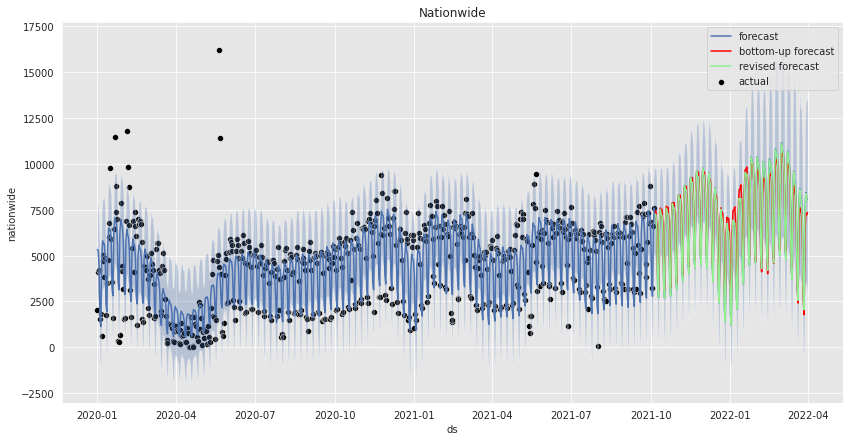

In [59]:
  fig, ax = plt.subplots(figsize=(14, 7))
  sns.scatterplot(x='ds', y='nationwide', label='actual', color='black' ,data=hts_group[['ds', 'nationwide']], ax=ax)  
  sns.lineplot(x='ds', y='yhat', label='forecast', data=fbprophet_forecasts['nationwide'][['ds','yhat']], ax=ax) 
  x=list(fbprophet_forecasts['nationwide']['ds'])
  upper = list(fbprophet_forecasts['nationwide']['yhat_upper'])
  lower = list(fbprophet_forecasts['nationwide']['yhat_lower'])
  ax.fill_between(x,lower, upper, alpha=0.3)
  sns.lineplot(x='ds', y='sum', label='bottom-up forecast', color='red', data=bottom_up_df[['ds','sum']], ax=ax) 
  sns.lineplot(x='ds', y='nationwide', label='revised forecast', color='lightgreen', data=revised_forecasts[['ds','nationwide']], ax=ax)
  ax.set_title('Nationwide')

In [ ]:
 fig, ax = plt.subplots(figsize=(14, 7))
  sns.scatterplot(x='ds', y='nationwide', label='actual', color='black' ,data=hts_group[['ds', 'nationwide']], ax=ax)  
  sns.lineplot(x='ds', y='yhat', label='forecast', data=fbprophet_forecasts['nationwide'][['ds','yhat']], ax=ax) 
  x=list(fbprophet_forecasts['nationwide']['ds'])
  upper = list(fbprophet_forecasts['nationwide']['yhat_upper'])
  lower = list(fbprophet_forecasts['nationwide']['yhat_lower'])
  ax.fill_between(x,lower, upper, alpha=0.3)
  sns.lineplot(x='ds', y='sum', label='bottom-up forecast', color='red', data=bottom_up_df[['ds','sum']], ax=ax) 
  sns.lineplot(x='ds', y='nationwide', label='revised forecast', color='lightgreen', data=revised_forecasts[['ds','nationwide']], ax=ax)
  ax.set_title('Nationwide')

In [ ]:
#Forecast value by product by zone with rmse and figure
grouped = group_data.groupby(["zone"])
products = data['product_tagging'].unique()
for zone in grouped.groups:
  for product in products:
    group = grouped.get_group(zone).rename(columns={'created_date': 'ds', product:'y'}) 
    m = Prophet(growth="linear", daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True,seasonality_mode='multiplicative', interval_width=0.95)
    m.fit(group)
    future = m.make_future_dataframe(periods=151)
    forecast = m.predict(future)
    print("Zone & Product:",zone,product)
    MSE = mean_squared_error(group['y'], forecast.iloc[:len(group['y'])].yhat)
    RMSE = math.sqrt(MSE)
    print("RMSE:", RMSE)
    print(forecast[['ds','yhat']])
    plot1 = m.plot(forecast)
    plt.show(plot1)
    plot2 = m.plot_components(forecast)
    plt.show(plot2)

NameError: ignored

In [ ]:
dir+'zone.csv'

In [ ]:
#Forecast value to csv for all product by zone
#Results link -> https://drive.google.com/file/d/1-D0kz3GSya2ctrkoFRF2jmteV0C486SM/view?usp=sharing

group = group_data
count = 0
filename = dir+'zone.csv'
import os
# os.remove(filename)
for g in group['zone'].sort_values(ascending=True).unique():
    count = count + 1
  #for column in columns:
    group_1 = group.query("zone=='"+g+"'").rename(columns={'created_date': 'ds'}) 
    group_1['y'] = group_1[products[0]] + group_1[products[1]] + group_1[products[2]]+ group_1[products[3]]+ group_1[products[4]]+ group_1[products[5]]+ group_1[products[6]]+ group_1[products[7]]
    group_1 = group_1[['ds','y']]
    m = Prophet(growth="linear", daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True,seasonality_mode='multiplicative', interval_width=0.95)
    m.fit(group_1)
    future = m.make_future_dataframe(periods=151)
    forecast = m.predict(future)
    #forecast['zone'] = g
    forecast.insert(0,'zone',g)
    
    
    print(g)
    print(count)
    print(len(group['zone'].unique()))
    header = False
    if(count == 1):
      header = True
    
    forecast.query("ds >'2021-09-01' and ds < '2022-01-01' ").merge(group_1,on='ds',how='left').to_csv(filename, mode='a', header=header, index=False)
    #if(count > 3):
      #break;
    

In [ ]:
#Forecast value by product by zone
#Results link -> https://drive.google.com/file/d/1-VY-YbAE0H2z9YCipQhRtrs6R8zlwL6l/view?usp=sharing
group = group_data
columns = products
count = 0
filename = dir+'zone_product.csv'

if file_exists(filename):
  os.remove(filename)
for g in group['zone'].sort_values(ascending=True).unique():
    for product in columns:
      count = count + 1
      group_1 = group.query("zone=='"+g+"'").rename(columns={'created_date': 'ds'})
      group_1['y'] = group_1[product]
      group_1 = group_1[['ds','y']]
      m = Prophet(growth="linear", daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True,seasonality_mode='multiplicative', interval_width=0.95)
      m.fit(group_1)
      future = m.make_future_dataframe(periods=151)
      forecast = m.predict(future)
      forecast.insert(0,'zone',g)
      forecast.insert(1,'product', product)
      
      
      print(g,product)
      print(count)
      print(len(group['zone'].unique())*len(columns))
      header = False
      if(count == 1):
        header = True
      
      forecast.query("ds >'2021-08-31' and ds < '2022-01-01' ").merge(group_1,on='ds',how='left').to_csv(filename, mode='a', header=header, index=False)


In [ ]:
products